In [46]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.layers import *
from sklearn.metrics import mean_squared_error



np.set_printoptions(threshold=np.inf)

In [2]:
raw_data = pd.read_csv('../data/train.csv')
raw_data['Temperature'] = raw_data['Temperature'].fillna(raw_data['Temperature'].mean())
raw_data['Humidity'] = raw_data['Humidity'].fillna(raw_data['Humidity'].mean())

C:\Users\Alexander\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def get_time(quarter, clock):
    split_time = clock.split(':')
    return (quarter-1)*15 + int(split_time[0]) + int(split_time[1])/60

def get_distance_to_touchdown(yard_line, possession_team, field_position):
    if possession_team != field_position:
        return yard_line
    else:
        return 100 - yard_line

def get_time_since_snap(time_handoff, time_snap):
    split_handoff = time_handoff.split(':')
    handoff_sec = int(split_handoff[1])*60 + int(split_handoff[2].split('.')[0])
    split_snap = time_handoff.split(':')
    snap_sec = int(split_snap[1])*60 + int(split_snap[2].split('.')[0])
    return float(handoff_sec) - float(snap_sec)

def get_height(player_height):
    split_height = player_height.split('-')
    return int(split_height[0])*12 + int(split_height[1])

def get_age(player_birth_date):
    return 2019 - int(player_birth_date.split('/')[2])

def encode_personnel(personnel):
    PERSONNELS = ['DB', 'DL', 'LB', 'OL', 'QB', 'RB', 'TE', 'WR']
    encoded_personnel = [0]*len(PERSONNELS)
    personnel = personnel.replace(' ','')
    for i in range(0,len(personnel),4):
        encoded_personnel[PERSONNELS.index(personnel[i+1:i+3])] += int(personnel[i])
    return encoded_personnel

def get_offense_features(formation, personnel):
    FORMATIONS = ['SHOTGUN','SINGLEBACK','JUMBO','PISTOL','I_FORM','ACE','WILDCAT','EMPTY']
    one_hot_formation = [int(f == formation) for f in FORMATIONS]
    return one_hot_formation + encode_personnel(personnel)

def get_defense_features(in_the_box, personnel):
    return [in_the_box] + encode_personnel(personnel)

def team_trans(string):
    if string == 'home':
        return 1
    else:
        return 0

In [4]:
# NEW VERSION (PART A), outputs nn_data, which is everything BUT player distribution
nn_input = []
nn_target = []
for _,play in raw_data.groupby(['PlayId']):
    state_features = []
    state_features.append(get_distance_to_touchdown(play['YardLine'].iloc[0], play['PossessionTeam'].iloc[0], play['FieldPosition'].iloc[0]))
    state_features.append(get_time(play['Quarter'].iloc[0],play['GameClock'].iloc[0]))
    state_features.append(play['Down'].iloc[0])
    state_features.append(play['Distance'].iloc[0])
    state_features.append(get_time_since_snap(play['TimeHandoff'].iloc[0], play['TimeSnap'].iloc[0]))
    offense_features = get_offense_features(play['OffenseFormation'].iloc[0], play['OffensePersonnel'].iloc[0])
    defense_features = get_defense_features(play['DefendersInTheBox'].iloc[0], play['DefensePersonnel'].iloc[0])
    for t,team in play.groupby(['Team']):
        team_features = []
        
        if t == 'home':
            team_features.append(team['HomeScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['HomeTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
        elif t == 'away':
            team_features.append(team['VisitorScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['VisitorTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
    print(type(state_features), type(offense_features), type(defense_features))
    print(type(state_features + offense_features + defense_features))
    if np.amax(np.isnan(state_features + offense_features + defense_features)) == 0:
        nn_input.append(state_features + offense_features + defense_features)
        nn_target.append(play['Yards'].iloc[0])

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'list'>
<class 'list'>
<class 'list'> <class 'list'> <class 'li

In [13]:
# NEW VERSION PART B, outputs c_nn data, which is just the distribution
c_nn_input = []
c_nn_target = []
for _,play in raw_data.groupby(['PlayId']):
    state_features = []
    offense_features = []
    defense_features = []
    
    for t,team in play.groupby(['Team']):
        team_features = []
        team_features.append(list(team['X']))
        team_features.append(list(team['Y']))
        team_features.append(list(team['A']))
        team_features.append(list(team['Dis']))
        team_features.append(list(team['Orientation']))
        team_features.append(list(team['Dir']))
        team_features.append(list(team['PlayerHeight'].apply(lambda x: get_height(x))))
        team_features.append(list(team['PlayerWeight']))
        #print(team)
        team_features.append(team['Team'].apply(lambda x: team_trans(x)))
        
    # team_features is length 8 list where entries are length 11 vectors
    #print(team_features)
    #print(len(team_features))
    #print(len(team_features[0]))
    if np.amax(np.isnan(team_features)) == 0:
        c_nn_input.append(team_features)
        c_nn_target.append(play['Yards'].iloc[0])

In [14]:
nn_input = np.stack(nn_input)
nn_target = np.array(nn_target)

c_nn_input = np.stack(c_nn_input)
c_nn_target = np.stack(c_nn_target)


In [15]:
print(nn_input.shape)
print(nn_target.shape)
print(type(nn_input))
print(type(nn_target))

print(c_nn_input.shape)
#print(c_nn_input[0])
print(c_nn_target.shape)
print(type(c_nn_input))
print(type(c_nn_target))

(23168, 32)
(23168,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(23157, 9, 11)
[[7.5820e+01 7.4780e+01 7.5430e+01 7.5900e+01 7.9760e+01 7.6470e+01
  7.4700e+01 7.8750e+01 7.4600e+01 7.4580e+01 7.4580e+01]
 [1.7560e+01 3.3210e+01 3.2410e+01 2.5120e+01 2.9490e+01 3.6910e+01
  1.9190e+01 3.0530e+01 3.1880e+01 2.9120e+01 2.8470e+01]
 [1.3900e+00 8.2000e-01 1.3600e+00 8.0000e-01 1.2200e+00 7.7000e-01
  1.4800e+00 3.3500e+00 1.5100e+00 6.9000e-01 1.5500e+00]
 [5.5000e-01 1.9000e-01 3.2000e-01 1.9000e-01 0.0000e+00 5.9000e-01
  5.1000e-01 3.8000e-01 1.7000e-01 2.2000e-01 2.4000e-01]
 [1.7897e+02 1.7882e+02 2.0708e+02 1.3301e+02 1.9218e+02 1.1202e+02
  1.5214e+02 1.6198e+02 2.1849e+02 1.6936e+02 2.0709e+02]
 [2.8415e+02 2.1590e+02 2.2276e+02 1.9855e+02 1.1086e+02 1.9509e+02
  2.7852e+02 2.4574e+02 2.6732e+02 2.4205e+02 2.5567e+02]
 [7.1000e+01 7.8000e+01 7.8000e+01 8.1000e+01 7.6000e+01 7.3000e+01
  7.0000e+01 7.0000e+01 7.3000e+01 7.5000e+01 7.7000e+01]
 [1.8500e+02 2.6500e+02 3.3500e+02

In [22]:
input_trn, input_val, target_trn, target_val = train_test_split(nn_input, nn_target, train_size=0.75)
input_ss = StandardScaler()
input_trn = input_ss.fit_transform(input_trn)
input_val = input_ss.transform(input_val)
#target_ss = StandardScaler()
#target_trn = target_ss.fit_transform(target_trn.reshape((-1,1)))
#target_val = target_ss.transform(target_val.reshape((-1,1)))

c_input_trn, c_input_val, c_target_trn, c_target_val = train_test_split(c_nn_input, c_nn_target, train_size=0.75)
#input_ss = StandardScaler()
#c_input_trn = input_ss.fit_transform(c_input_trn)
#c_input_val = input_ss.transform(c_input_val)
#c_target_ss = StandardScaler()
#c_target_trn = target_ss.fit_transform(c_target_trn.reshape((-1,1)))
#c_target_val = target_ss.transform(c_target_val.reshape((-1,1)))

input_trn = np.delete(input_trn, [1,2,3,4,5,6,7,8,9], axis=0)
target_trn = np.delete(target_trn, [1,2,3,4,5,6,7,8,9])

input_val = np.delete(input_val, [1,2], axis=0)
target_val = np.delete(target_val, [1,2])

print(input_trn.shape)
print(input_val.shape)

print(target_trn.shape)
print(target_val.shape)

print(c_input_trn.shape)
print(c_input_val.shape)

(17367, 32)
(5790, 32)
(17367,)
(5790,)
(17367, 9, 11)
(5790, 9, 11)


In [ ]:


# model 1 handles game state
model1 = Sequential()
print(c_input_trn.shape[1:])
model1.add(Dense(units=8, activation='sigmoid', input_shape=(input_trn.shape[1:])))
model1.add(Dense(units=8, activation = 'relu'))
model1.add(Dense(units=8))

if True:
    # model 2 handles "convolution", old
    model2 = Sequential()
    print(input_trn.shape[1:])
    model2.add(Dense(units=256, activation='sigmoid', input_shape=(c_input_trn.shape[1], c_input_trn.shape[2])))
    model2.add(Dense(units=128, activation='sigmoid'))
    model2.add(Dense(units=64, activation='sigmoid'))
    model2.add(Dense(units=32, activation='sigmoid'))
    model2.add(Dense(units=16))
    model2.add(Flatten())

if False:
    # model 2 handles convolution
    print(c_input_trn.shape[1], c_input_trn.shape[2])
    model2 = Sequential([
      Conv2D(4, 2, input_shape=(c_input_trn.shape[1], c_input_trn.shape[2])),
      MaxPooling2D(pool_size=3),
      Flatten(),
    ])

mergedOut = Concatenate()([model1.output,model2.output])
mergedOut = Dense(8, activation = 'relu')(mergedOut)
mergedOut = Dense(4, activation = 'relu')(mergedOut)
mergedOut = Dense(2, activation = 'relu')(mergedOut)

mergedOut = Dense(1, activation = 'linear')(mergedOut)

from keras.models import Model

newModel = Model([model1.input,model2.input], mergedOut)

newModel.compile(optimizer='adam',loss='mse',metrics=['mse'])

history = newModel.fit(x = [input_trn, c_input_trn], y = target_trn, epochs = 100, verbose = 1, validation_data = ([input_val, c_input_val], target_val)) 
# https://stackoverflow.com/questions/45979848/merge-2-sequential-models-in-keras
# 

yhat = newModel.predict([input_val, c_input_val])

print(mean_squared_error(yhat, target_val))

#callbacks = [EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=False)]

(9, 11)
(32,)
Train on 17367 samples, validate on 5790 samples
Epoch 1/100
17367/17367 [==============================] - 5s 263us/step - loss: 42.4146 - mean_squared_error: 42.4146 - val_loss: 38.9018 - val_mean_squared_error: 38.9018
Epoch 2/100
17367/17367 [==============================] - 3s 169us/step - loss: 41.7792 - mean_squared_error: 41.7792 - val_loss: 38.7315 - val_mean_squared_error: 38.7315
Epoch 3/100
17367/17367 [==============================] - 3s 190us/step - loss: 41.6288 - mean_squared_error: 41.6288 - val_loss: 38.6506 - val_mean_squared_error: 38.6506
Epoch 4/100
17367/17367 [==============================] - 3s 161us/step - loss: 41.5930 - mean_squared_error: 41.5930 - val_loss: 38.6893 - val_mean_squared_error: 38.6893
Epoch 5/100
17367/17367 [==============================] - 3s 184us/step - loss: 41.5477 - mean_squared_error: 41.5477 - val_loss: 38.7608 - val_mean_squared_error: 38.7608
Epoch 6/100
17367/17367 [==============================] - 3s 184us/step

Epoch 48/100
17367/17367 [==============================] - 3s 146us/step - loss: 40.4778 - mean_squared_error: 40.4778 - val_loss: 39.2415 - val_mean_squared_error: 39.2415
Epoch 49/100
17367/17367 [==============================] - 2s 143us/step - loss: 40.4574 - mean_squared_error: 40.4574 - val_loss: 38.7547 - val_mean_squared_error: 38.7547
Epoch 50/100
17367/17367 [==============================] - 3s 145us/step - loss: 40.4194 - mean_squared_error: 40.4194 - val_loss: 38.9295 - val_mean_squared_error: 38.9295
Epoch 51/100
17367/17367 [==============================] - 2s 143us/step - loss: 40.4026 - mean_squared_error: 40.4026 - val_loss: 39.1688 - val_mean_squared_error: 39.1688
Epoch 52/100
17367/17367 [==============================] - 3s 169us/step - loss: 40.3043 - mean_squared_error: 40.3043 - val_loss: 38.8805 - val_mean_squared_error: 38.8805
Epoch 53/100
17367/17367 [==============================] - 3s 144us/step - loss: 40.2366 - mean_squared_error: 40.2366 - val_loss

17367/17367 [==============================] - 5s 263us/step - loss: 38.0098 - mean_squared_error: 38.0098 - val_loss: 41.2202 - val_mean_squared_error: 41.2202
Epoch 96/100
17367/17367 [==============================] - 7s 409us/step - loss: 38.3047 - mean_squared_error: 38.3047 - val_loss: 41.5248 - val_mean_squared_error: 41.5248
Epoch 97/100
17367/17367 [==============================] - 7s 394us/step - loss: 38.0399 - mean_squared_error: 38.0399 - val_loss: 40.2220 - val_mean_squared_error: 40.2220
Epoch 98/100
 1376/17367 [=>............................] - ETA: 10s - loss: 35.6634 - mean_squared_error: 35.6634

In [40]:
print(np.mean((yhat - target_val)**2))
plt.scatter(yhat, target_val)

NameError: name 'yhat' is not defined

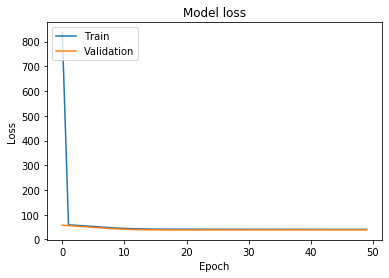

In [41]:
#history = model.fit(x=input_trn, y=target_trn, epochs=2000, verbose=0, validation_data=(input_val,target_val))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

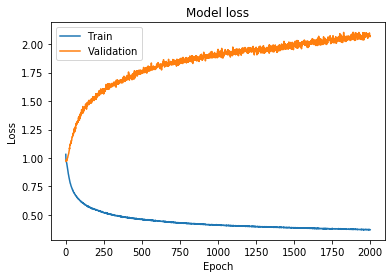